In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

2025-05-13 20:09:50.504830: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 20:09:50.505367: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 20:09:50.507641: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 20:09:50.513668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747148990.523526  347783 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747148990.52

In [2]:
# Load datasets
style_df = pd.read_csv('/home/hammad/fyp/style_prediction_dataset.csv')
category_df = pd.read_csv('/home/hammad/fyp/category_prediction_dataset.csv')
color_df = pd.read_csv('/home/hammad/fyp/color_prediction_dataset.csv')

In [3]:
color_df['baseColour_encoded'].value_counts()

baseColour_encoded
0     4742
1     4501
10    3759
4     2173
2     1884
9     1572
3     1457
7      930
8      884
11     705
6      238
5      101
Name: count, dtype: int64

In [4]:
color_df.head()

,id,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,baseColour_encoded
0,15970,0.325631,0.961932,0.000000,0.549981,0.000000,0.056022,0.508034,0.388490,0.008825,...,0.223776,0.124558,2.046997,0.000000,0.000000,0.433070,0.234684,0.064110,1.254325,1
1,39386,0.670931,1.461553,0.154584,0.383389,0.460850,0.008900,0.812330,0.004201,0.344588,...,0.065233,1.082466,0.231429,0.107079,0.002723,0.579104,0.000000,0.000000,1.954522,1
2,21379,0.195744,0.803393,0.004324,2.545139,0.075638,0.109980,2.759297,0.664183,0.075709,...,0.000000,0.000053,0.167400,0.071858,0.000000,0.659216,0.000000,0.110951,3.961849,0
3,53759,0.096383,1.703673,0.056809,1.617223,0.011546,0.000000,1.127666,0.307086,0.000000,...,0.205928,0.140345,1.801834,0.000000,0.000000,0.082535,0.078035,0.242948,1.523945,4
4,1855,0.035023,1.326588,0.000000,0.991414,0.000000,0.000000,0.770858,0.419605,0.103250,...,0.004316,0.195267,1.943198,0.046978,0.000000,0.003337,0.024109,0.403093,0.126377,4


In [5]:
index_to_color = {
    0: 'Black',
    1: 'Blue',
    2: 'Brown',
    3: 'Green',
    4: 'Grey',
    5: 'Multi',
    6: 'Orange',
    7: 'Pink',
    8: 'Purple',
    9: 'Red',
    10: 'White',
    11: 'Yellow'
}

In [6]:
def prepare_data(df, label_column):
    # Drop non-feature columns (id, label column)
    X = df.drop(columns=['id', label_column])
    y = df[label_column].values

    # Normalize features (gender + 2048 dims)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

    return X_train, X_test, y_train, y_test, scaler


In [7]:
# Generalized class weight calculator
def get_class_weights(y_train):
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    return dict(zip(classes, weights))


In [8]:
def create_mlp_model(input_dim, output_classes):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(output_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [9]:
def create_mlp_model_for_color(input_dim, output_classes):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dropout(0.2),

        Dense(output_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [10]:
# ========== STYLE MODEL ==========
X_train_s, X_test_s, y_train_s, y_test_s, style_scaler = prepare_data(style_df, 'style_label')
style_class_weights = get_class_weights(y_train_s)
style_model = create_mlp_model(X_train_s.shape[1], output_classes=3)

style_model.fit(X_train_s, y_train_s,
                validation_data=(X_test_s, y_test_s),
                epochs=50,
                batch_size=64,
                class_weight=style_class_weights,
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])


2025-05-13 20:11:33.965840: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7063 - loss: 0.7607 - val_accuracy: 0.7577 - val_loss: 0.5965
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8060 - loss: 0.3804 - val_accuracy: 0.8150 - val_loss: 0.5070
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8166 - loss: 0.3407 - val_accuracy: 0.7930 - val_loss: 0.4988
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8336 - loss: 0.2949 - val_accuracy: 0.8495 - val_loss: 0.3940
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8514 - loss: 0.2637 - val_accuracy: 0.8516 - val_loss: 0.3690
Epoch 6/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8653 - loss: 0.2322 - val_accuracy: 0.8484 - val_loss: 0.3698
Epoch 7/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8696 - loss: 0.2267 - val_accuracy: 0.8168 - val_loss: 0.4059
Epoch 8/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8745 - loss: 0.2145 - val_accu

In [11]:
# ========== CATEGORY MODEL ==========
X_train_c, X_test_c, y_train_c, y_test_c, category_scaler = prepare_data(category_df, 'category_label')
category_class_weights = get_class_weights(y_train_c)
category_model = create_mlp_model(X_train_c.shape[1], output_classes=3)

category_model.fit(X_train_c, y_train_c,
                   validation_data=(X_test_c, y_test_c),
                   epochs=50,
                   batch_size=64,
                   class_weight=category_class_weights,
                   callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])


Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9631 - loss: 0.1559 - val_accuracy: 0.9972 - val_loss: 0.0230
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9923 - loss: 0.0508 - val_accuracy: 0.9963 - val_loss: 0.0304
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9969 - loss: 0.0157 - val_accuracy: 0.9969 - val_loss: 0.0202
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9972 - loss: 0.0140 - val_accuracy: 0.9963 - val_loss: 0.0199
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9970 - loss: 0.0113 - val_accuracy: 0.9963 - val_loss: 0.0211
Epoch 6/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9975 - loss: 0.0098 - val_accuracy: 0.9978 - val_loss: 0.0162
Epoch 7/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9986 - loss: 0.0115 - val_accuracy: 0.9952 - val_loss: 0.0223
Epoch 8/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9980 - loss: 0.0082 - val_accu

In [12]:
# ========== BASECOLOUR MODEL ==========
X_train_b, X_test_b, y_train_b, y_test_b, color_scaler = prepare_data(color_df, 'baseColour_encoded')
color_class_weights = get_class_weights(y_train_b)
color_model = create_mlp_model_for_color(X_train_b.shape[1], output_classes=len(np.unique(y_train_b)))

color_model.fit(X_train_b, y_train_b,
                validation_data=(X_test_b, y_test_b),
                epochs=50,
                batch_size=64,
                class_weight=color_class_weights,
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])


Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3779 - loss: 2.0570 - val_accuracy: 0.6157 - val_loss: 1.1686
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5943 - loss: 1.1737 - val_accuracy: 0.6538 - val_loss: 1.0305
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6379 - loss: 0.9852 - val_accuracy: 0.6871 - val_loss: 0.9484
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6875 - loss: 0.8298 - val_accuracy: 0.6730 - val_loss: 0.9774
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6963 - loss: 0.7760 - val_accuracy: 0.7102 - val_loss: 0.8784
Epoch 6/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7251 - loss: 0.6700 - val_accuracy: 0.7155 - val_loss: 0.8807
Epoch 7/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7450 - loss: 0.6135 - val_accuracy: 0.7146 - val_loss: 0.8653
Epoch 8/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7494 - loss: 0.6049 - val_accu

In [13]:
# ========== EVALUATION ==========
style_loss, style_acc = style_model.evaluate(X_test_s, y_test_s)
category_loss, category_acc = category_model.evaluate(X_test_c, y_test_c)
color_loss, color_acc = color_model.evaluate(X_test_b, y_test_b)

print(f"BaseColour Accuracy: {color_acc:.4f}")
print(f"Style Accuracy: {style_acc:.4f}")
print(f"Category Accuracy: {category_acc:.4f}")

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8884 - loss: 0.3015
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9972 - loss: 0.0138
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7275 - loss: 0.8397
BaseColour Accuracy: 0.7281
Style Accuracy: 0.8767
Category Accuracy: 0.9978


In [14]:
def plot_confusion(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


In [15]:
def plot_confusion_matrix_for_color(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 15))  # adjust for readability
    sns.heatmap(cm, annot=False, cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report for Style:
              precision    recall  f1-score   support

      casual       0.96      0.88      0.92      3515
      formal       0.72      0.93      0.81       363
  sportswear       0.66      0.85      0.74       712

    accuracy                           0.88      4590
   macro avg       0.78      0.88      0.82      4590
weighted avg       0.90      0.88      0.88      4590



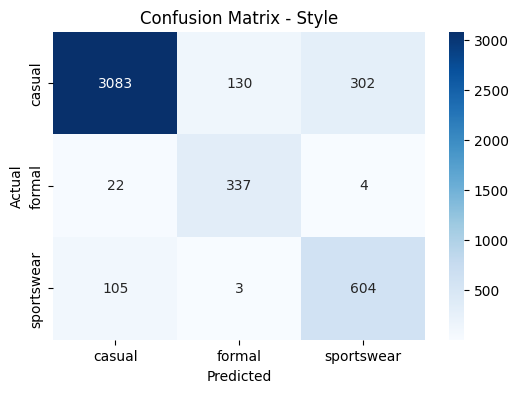

In [16]:
## Performance Metrics for Style Model
y_pred_s = style_model.predict(X_test_s)
y_pred_s_classes = y_pred_s.argmax(axis=1)

print("Classification Report for Style:")
print(classification_report(y_test_s, y_pred_s_classes, target_names=["casual", "formal", "sportswear"]))

plot_confusion(y_test_s, y_pred_s_classes, ["casual", "formal", "sportswear"], "Confusion Matrix - Style")


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report for Category:
              precision    recall  f1-score   support

      bottom       0.99      0.99      0.99       506
    footwear       1.00      1.00      1.00      1464
         top       1.00      1.00      1.00      2620

    accuracy                           1.00      4590
   macro avg       1.00      1.00      1.00      4590
weighted avg       1.00      1.00      1.00      4590



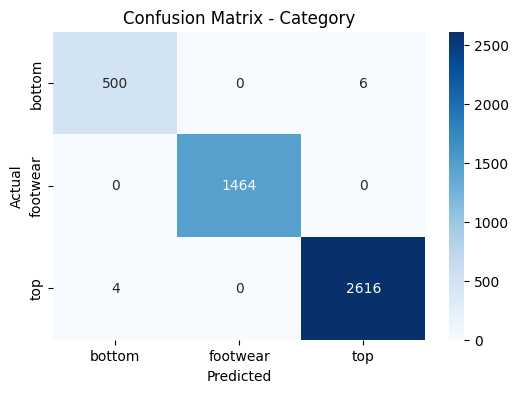

In [17]:
## Performance Metrics for Category Model
y_pred_c = category_model.predict(X_test_c)
y_pred_c_classes = y_pred_c.argmax(axis=1)

print("Classification Report for Category:")
print(classification_report(y_test_c, y_pred_c_classes, target_names=["bottom", "footwear", "top"]))

plot_confusion(y_test_c, y_pred_c_classes, ["bottom", "footwear", "top"], "Confusion Matrix - Category")


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report for Base Colour Prediction:
              precision    recall  f1-score   support

       Black       0.81      0.78      0.80       949
        Blue       0.86      0.69      0.77       900
       Brown       0.67      0.66      0.66       377
       Green       0.69      0.76      0.73       291
        Grey       0.52      0.61      0.56       435
       Multi       0.19      0.35      0.25        20
      Orange       0.49      0.67      0.57        48
        Pink       0.68      0.73      0.70       186
      Purple       0.58      0.73      0.65       177
         Red       0.75      0.82      0.78       314
       White       0.79      0.77      0.78       752
      Yellow       0.63      0.77      0.70       141

    accuracy                           0.73      4590
   macro avg       0.64      0.69      0.66      4590
weighted avg       0.74      0.73      0.73      4590



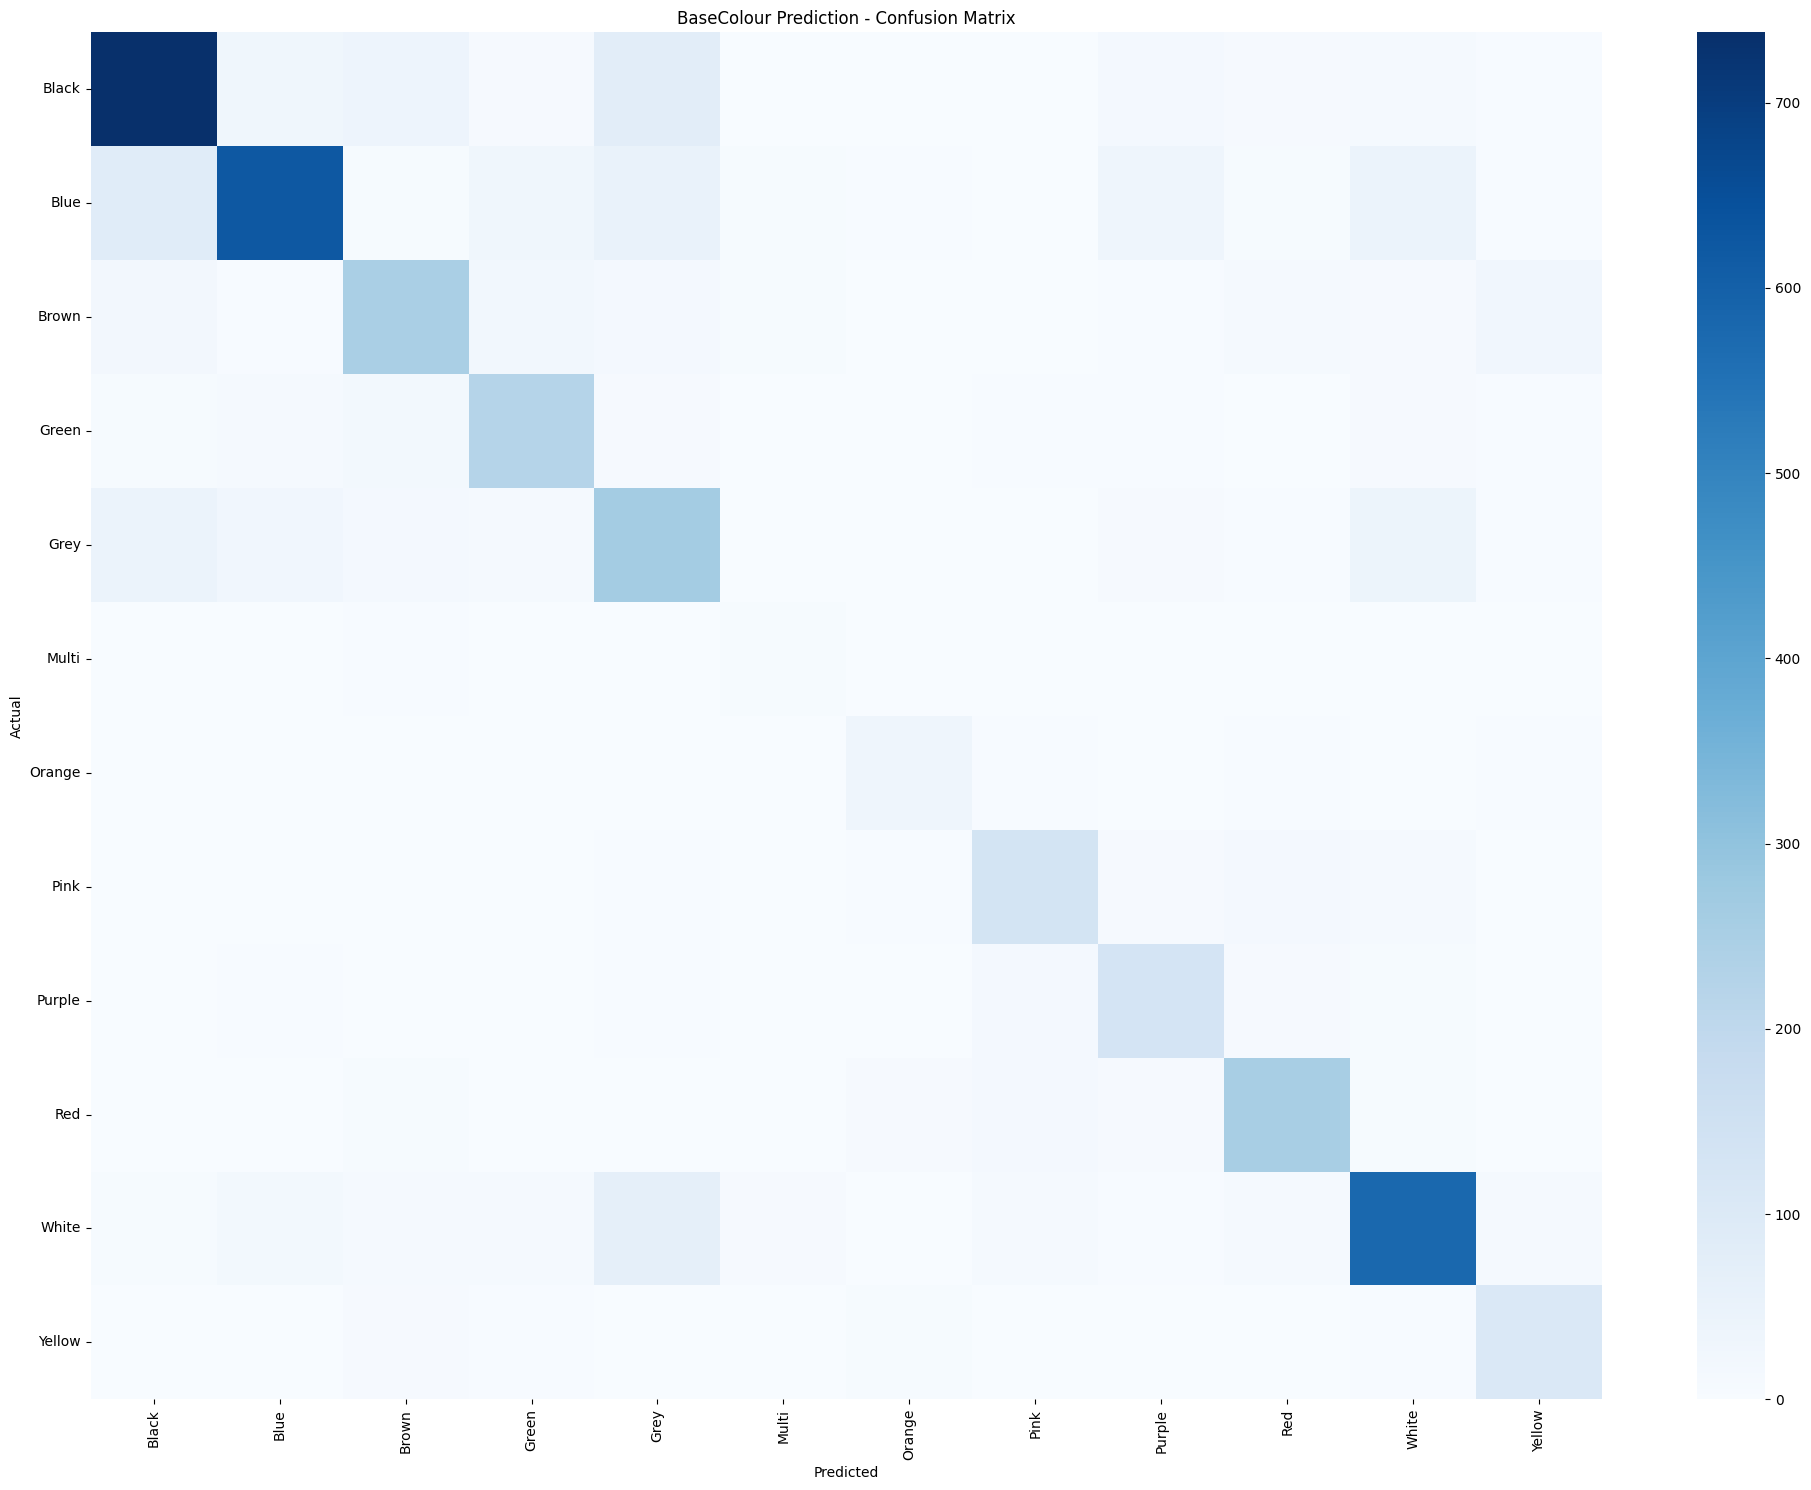

In [18]:
y_pred_b = color_model.predict(X_test_b)
y_pred_b_classes = y_pred_b.argmax(axis=1)

print("Classification Report for Base Colour Prediction:")
print(classification_report(
    y_test_b, y_pred_b_classes,
    target_names=[index_to_color[i] for i in sorted(index_to_color.keys())]
))

plot_confusion_matrix_for_color(y_test_b, y_pred_b_classes,
                      labels=[index_to_color[i] for i in sorted(index_to_color.keys())],
                      title="BaseColour Prediction - Confusion Matrix")

In [19]:
import joblib

In [20]:
# Save Keras models
style_model.save("style_mlp_model.keras")
category_model.save("category_mlp_model.keras")
color_model.save("color_mlp_model.keras")
# Save scalers
joblib.dump(style_scaler, "style_scaler.pkl")
joblib.dump(category_scaler, "category_scaler.pkl")
joblib.dump(color_scaler, "color_scaler.pkl")

['color_scaler.pkl']